In [2]:
import numpy as np
from tensorflow.keras.models import Model, load_model
import tensorflow.keras.backend as K
from scipy.stats import pearsonr, spearmanr
import matplotlib.pyplot as plt
import sys
sys.path.append('../python_scripts/')
import correlations
sys.path.append('../imported_code/svcca/')
import cca_core, pwcca

In [1]:
'''
RSA: Create an RDM for each activation layer (90 total) and get correlations between pairings of RDMs
'''
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.layers import Flatten
from scipy.stats import pearsonr, spearmanr

import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"
_, testData = correlations.make_train_data()
x_predict, y_predict = correlations.make_predict_data(testData)
# Function to correlate 2 RDMs
def correlate(RDM_1, RDM_2):
    print('Making correlations...')
    assert len(RDM_1) == len(RDM_2)
    # first flatten all the relevant values
    arr_1 = RDM_1[np.triu_indices(n=num_imgs, k=1)]
    arr_2 = RDM_2[np.triu_indices(n=num_imgs, k=1)]
    # Get Pearson correlation
    return pearsonr(arr_1, arr_2)[0]


num_images = len(x_predict) # 1000
RDM_list = np.empty((90, 1000, 1000)) #layer * instance, images, images
# Loop through network instances
# instance_0.h5  instance_1.h5  instance_10.h5  instance_13.h5  instance_2.h5  instance_3.h5  instance_4.h5  instance_6.h5  instance_7.h5  instance_8.h5	instance_9.h5

for i in [0, 2, 3, 4, 6, 7, 8, 9, 10, 13]:
    print('Working on model', str(i))
    K.clear_session()
    full_model = load_model('../outputs/models/primary/Version_5/instance_' + str(i) + '.h5')
    inp = full_model.input
    # Loop through layers
    for j in range(0, 9):
        print('Layer', str(j))
        out = full_model.layers[j].output
        # Flatten representation if needed
        if len(out.shape) != 2:
            out = Flatten()(out)
        temp_model = Model(inputs=inp, outputs=out)
        # Predict on x_predict, transpose for spearman
        print('Getting representation...')
        representations = temp_model.predict(x_predict).T
        print(representations.shape)
        print('Getting RDM...')
        RDM_list[10 * j + i] = spearmanr(representations, representations)[0][:num_images, :num_images]
 
np.save('RDM_list.npy', RDM_list)
print('Done gathering RDMs, now correlations')
correlations = np.empty((90, 90))
for i in range(correlations.shape[0]):
    for j in range(correlations.shape[1]):
        print('Correlation', str(i), ',', str(j))
        correlations[i, j] = correlate(RDM_list[i], RDM_list[j])

np.save('all_cnn_c_version_5_correlations.npy', correlations)
print('Done!')    
    

NameError: name 'correlations' is not defined

In [29]:
from sklearn.manifold import MDS
embedding = MDS(n_components=2, dissimilarity='precomputed')
X_transformed = embedding.fit_transform(RDM_list[5].astype('float64'))
print(X_transformed.shape)

(1000, 2)


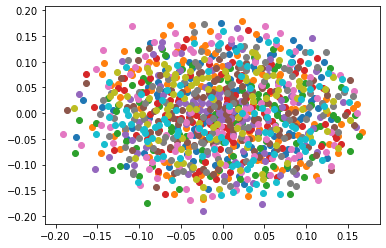

In [30]:
for i in range(10):
    plt.scatter(X_transformed[i*100 : (i+1)*100, 0], X_transformed[i*100 : (i+1)*100, 1])
plt.show()

(1000, 2)


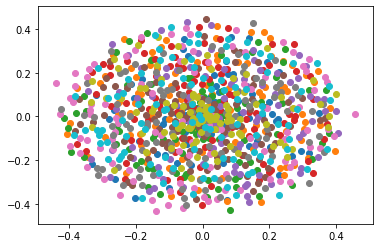

In [28]:
X_transformed1 = embedding.fit_transform(RDM_list[81].astype('float64'))
print(X_transformed.shape)
for i in range(10):
    plt.scatter(X_transformed1[i*100 : (i+1)*100, 0], X_transformed1[i*100 : (i+1)*100, 1])
plt.show()

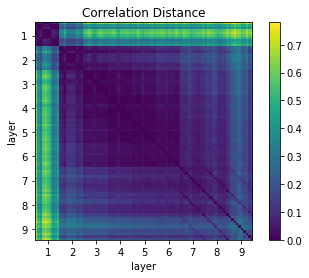

In [38]:
import matplotlib.pyplot as plt
correlations = np.load('all_cnn_c_version_4_correlations.npy')
correlations_distance = 1 - correlations
plt.title('Correlation Distance')
plt.xlabel('layer')
plt.xticks(ticks=[5, 15, 25, 35, 45, 55, 65, 75, 85],
           labels=[1, 2, 3, 4, 5, 6, 7, 8, 9])
plt.yticks(ticks=[5, 15, 25, 35, 45, 55, 65, 75, 85],
           labels=[1, 2, 3, 4, 5, 6, 7, 8, 9])
plt.ylabel('layer')

plt.imshow(correlations_distance)
plt.colorbar()

In [2]:
'''
RSA: Create an RDM for each activation layer (90 total) and get correlations between pairings of RDMs
'''
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.layers import Flatten
from scipy.stats import pearsonr, spearmanr

# Function to correlate 2 RDMs
def correlate(RDM_1, RDM_2):
    print('Making correlations...')
    assert len(RDM_1) == len(RDM_2)
    num_unique_entries = 499500 # for 1000x1000
    arr_1 = np.empty((num_unique_entries))
    arr_2 = np.empty((num_unique_entries))
    counter = 0
    # first flatten all the relevant values
    for i in range(len(RDM_1)): #1000
        for j in range(i + 1, len(RDM_1)):
            arr_1[counter] = RDM_1[i, j]
            arr_2[counter] = RDM_2[i, j]
            counter += 1
    # Get Pearson correlation
    return pearsonr(arr_1, arr_2)[0]


num_images = len(x_predict) # 1000
RDM_list = np.empty((90, 1000, 1000)) #layer * instance, images, images
# Loop through network instances
for i in range(10):
    print('Working on model', str(i))
    K.clear_session()
    full_model = load_model('../outputs/models/primary/Version_4/all_cnn_c_instance_' + str(i) + '.h5')
    inp = full_model.input
    # Loop through layers
    for j in range(0, 9):
        print('Layer', str(j))
        out = full_model.layers[j].output
        # Flatten representation if needed
        if len(out.shape) != 2:
            out = Flatten()(out)
        temp_model = Model(inputs=inp, outputs=out)
        # Predict on x_predict, transpose for spearman
        print('Getting representation...')
        representations = temp_model.predict(x_predict).T
        print(representations.shape)
        print('Getting RDM...')
        RDM_list[10 * j + i] = spearmanr(representations, representations)[0][:num_images, :num_images]
        
print('Done gathering RDMs, now correlations')
correlations = np.empty((90, 90))
for i in range(correlations.shape[0]):
    for j in range(correlations.shape[1]):
        print('Correlation', str(i), ',', str(j))
        correlations[i, j] = correlate(RDM_list[i], RDM_list[j])

np.save('all_cnn_c_version_4_correlations.npy', correlations)
print('Done!')    
    

Working on model 0
Layer 0
Getting representation...
(98304, 1000)
Getting RDM...
Layer 1
Getting representation...
(98304, 1000)
Getting RDM...
Layer 2
Getting representation...
(24576, 1000)
Getting RDM...
Layer 3
Getting representation...
(49152, 1000)
Getting RDM...
Layer 4
Getting representation...
(49152, 1000)
Getting RDM...
Layer 5
Getting representation...
(12288, 1000)
Getting RDM...
Layer 6
Getting representation...
(6912, 1000)
Getting RDM...
Layer 7
Getting representation...
(6912, 1000)
Getting RDM...
Layer 8
Getting representation...
(360, 1000)
Getting RDM...
Working on model 1
Layer 0
Getting representation...
(98304, 1000)
Getting RDM...
Layer 1
Getting representation...
(98304, 1000)
Getting RDM...
Layer 2
Getting representation...
(24576, 1000)
Getting RDM...
Layer 3
Getting representation...
(49152, 1000)
Getting RDM...
Layer 4
Getting representation...
(49152, 1000)
Getting RDM...
Layer 5
Getting representation...
(12288, 1000)
Getting RDM...
Layer 6
Getting repre

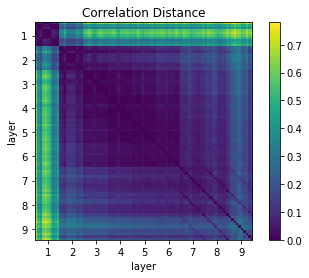

In [2]:
import matplotlib.pyplot as plt
correlations = np.load('all_cnn_c_version_4_correlations.npy')
correlations_distance = 1 - correlations
plt.title('Correlation Distance')
plt.xlabel('layer')
plt.xticks(ticks=[5, 15, 25, 35, 45, 55, 65, 75, 85],
           labels=[1, 2, 3, 4, 5, 6, 7, 8, 9])
plt.yticks(ticks=[5, 15, 25, 35, 45, 55, 65, 75, 85],
           labels=[1, 2, 3, 4, 5, 6, 7, 8, 9])
plt.ylabel('layer')

plt.imshow(correlations_distance)
plt.colorbar()

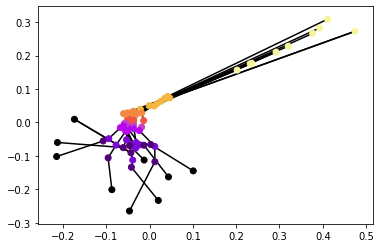

In [4]:
from sklearn.manifold import MDS
embedding = MDS(n_components=2, dissimilarity='precomputed')
X_transformed = embedding.fit_transform(correlations_distance)
colors = ['#f5f59d', '#f5b642', '#f58742', '#f55442', '#c940c5',
          '#b407ed', '#7d09d6', '#50017a', '#000000']
plt.plot(X_transformed[::10, 0], X_transformed[::10, 1], linestyle='-', color='black', zorder=1)
plt.plot(X_transformed[1::10, 0], X_transformed[1::10, 1], linestyle='-', color='black', zorder=1)
plt.plot(X_transformed[2::10, 0], X_transformed[2::10, 1], linestyle='-', color='black', zorder=1)
plt.plot(X_transformed[3::10, 0], X_transformed[3::10, 1], linestyle='-', color='black', zorder=1)
plt.plot(X_transformed[4::10, 0], X_transformed[4::10, 1], linestyle='-', color='black', zorder=1)
plt.plot(X_transformed[5::10, 0], X_transformed[5::10, 1], linestyle='-', color='black', zorder=1)
plt.plot(X_transformed[6::10, 0], X_transformed[6::10, 1], linestyle='-', color='black', zorder=1)
plt.plot(X_transformed[7::10, 0], X_transformed[7::10, 1], linestyle='-', color='black', zorder=1)
plt.plot(X_transformed[8::10, 0], X_transformed[8::10, 1], linestyle='-', color='black', zorder=1)
plt.plot(X_transformed[::10, 0], X_transformed[::10, 1], linestyle='-', color='black', zorder=1)

plt.scatter(X_transformed[::10, 0], X_transformed[::10, 1], marker='o', color=colors, zorder=2)
plt.scatter(X_transformed[1::10, 0], X_transformed[1::10, 1], marker='o', color=colors, zorder=2)
plt.scatter(X_transformed[2::10, 0], X_transformed[2::10, 1], marker='o', color=colors, zorder=2)
plt.scatter(X_transformed[3::10, 0], X_transformed[3::10, 1], marker='o', color=colors, zorder=2)
plt.scatter(X_transformed[4::10, 0], X_transformed[4::10, 1], marker='o', color=colors, zorder=2)
plt.scatter(X_transformed[5::10, 0], X_transformed[5::10, 1], marker='o', color=colors, zorder=2)
plt.scatter(X_transformed[6::10, 0], X_transformed[6::10, 1], marker='o', color=colors, zorder=2)
plt.scatter(X_transformed[7::10, 0], X_transformed[7::10, 1], marker='o', color=colors, zorder=2)
plt.scatter(X_transformed[8::10, 0], X_transformed[8::10, 1], marker='o', color=colors, zorder=2)


In [2]:
'''
SVCCA Pt. 1: Get flattened representations by avg pooling
'''

# For SVCCA, 1. prep data by avg pooling, 2. find threshold for each layer of each network
# 3. SVCCA each network with each other network, plot into graph


# Helper function to find threshold for each layer            
def search_threshold(acts):
    print('Getting threshold...')
    target = 0.99
    start = 0
    end = acts.shape[0]
    ans = -1
    while start <= end:
        mid = (start + end) // 2
        # Move to right side if target is 
        # greater. 
        s = np.linalg.svd(acts - np.mean(acts, axis=1, keepdims=True), full_matrices=False)[1]
        # Note: normally comparing floating points is a bad bad but the precision we need is low enough
        if (np.sum(s[:mid])/np.sum(s) <= target): 
            start = mid + 1;
        # Move left side. 
        else: 
            ans = mid; 
            end = mid - 1;
    # Prevent silent failure
    if ans == -1:
        raise
    print('Sanity check, achieved', np.sum(s[:ans])/np.sum(s), 'variance with', ans, 'neurons')
    return ans

num_images = len(x_predict) # 1000
num_networks = 10
num_layers = 9
rep_list = [[], [], [], [], [], [], [], [], []]
thresholds = np.empty((num_layers * num_networks))

# Loop through network instances
for i in range(num_networks):
    print('Working on model', str(i))
    K.clear_session()
    full_model = load_model('../outputs/models/primary/Version_4/all_cnn_c_instance_' + str(i) + '.h5')
    inp = full_model.input
    # Loop through layers
    for j in range(num_layers):
        print('Layer', str(j))
        out = full_model.layers[j].output
        temp_model = Model(inputs=inp, outputs=out)
        # Predict on x_predict
        print('Getting representation...')
        representations = temp_model.predict(x_predict)
        print('Old shape:', representations.shape)
        # Average pool along spacial dimensions, transpose to fit shape (imgs, neurons)
        if (len(representations.shape) > 2):
            avg = np.mean(representations, axis=(1,2)).T
            print('Avg shape:', avg.shape)
        else:
            avg = representations.T
            print('No need to flatten')
        rep_list[j].append(avg)
        thresholds[num_networks * j + i] = search_threshold(avg)
        
    '''
SVCCA Pt. 2: Run SVCCA on every pairing of flattened representations (90 total) and save results
'''

# Helper Function for svcca
def svcca(acts1, acts2, threshold1, threshold2):
    print('Running SVCCA...')

    # Mean subtract activations
    cacts1 = acts1 - np.mean(acts1, axis=1, keepdims=True)
    cacts2 = acts2 - np.mean(acts2, axis=1, keepdims=True)

    # Perform SVD
    U1, s1, V1 = np.linalg.svd(cacts1, full_matrices=False)
    U2, s2, V2 = np.linalg.svd(cacts2, full_matrices=False)
    svacts1 = np.dot(s1[:threshold1]*np.eye(threshold1), V1[:threshold1])
    svacts2 = np.dot(s2[:threshold2]*np.eye(threshold2), V2[:threshold2])
    print('acts1 shape:', svacts1.shape)
    print('acts2 shape:', svacts2.shape)
    svcca_results = cca_core.get_cca_similarity(svacts1, svacts2, epsilon=1e-10, verbose=False)['cca_coef1']
    return np.mean(svcca_results)
     
print('Done preprocessing representations and thresholds, now CCA')
cca_correlations = np.empty((num_layers * num_networks, num_layers * num_networks))
for i in range(cca_correlations.shape[0]):
    for j in range(cca_correlations.shape[1]):
        print('Correlation', str(i), ',', str(j))
        
        layer_i = i // num_networks
        network_i = i % num_networks
        layer_j = j // num_networks
        network_j = j % num_networks
        acts1 = rep_list[layer_i][network_i]
        acts2 = rep_list[layer_j][network_j]
        
        thresh1 = int(thresholds[i])
        thresh2 = int(thresholds[j])
        
        # Do svcca
        print('Thresholds:', str(thresh1), str(thresh2))
        cca_correlations[i, j] = svcca(acts1, acts2, thresh1, thresh2)

np.save('cca_correlations_version_4.npy', cca_correlations)
print('Done!')

Working on model 0
Layer 0
Getting representation...
Old shape: (1000, 32, 32, 96)
Avg shape: (96, 1000)
Getting threshold...
Sanity check, achieved 0.99002934 variance with 85 neurons
Layer 1
Getting representation...
Old shape: (1000, 32, 32, 96)
Avg shape: (96, 1000)
Getting threshold...
Sanity check, achieved 0.9901557 variance with 80 neurons
Layer 2
Getting representation...
Old shape: (1000, 16, 16, 96)
Avg shape: (96, 1000)
Getting threshold...
Sanity check, achieved 0.99016666 variance with 80 neurons
Layer 3
Getting representation...
Old shape: (1000, 16, 16, 192)
Avg shape: (192, 1000)
Getting threshold...
Sanity check, achieved 0.9904807 variance with 162 neurons
Layer 4
Getting representation...
Old shape: (1000, 16, 16, 192)
Avg shape: (192, 1000)
Getting threshold...
Sanity check, achieved 0.9903277 variance with 164 neurons
Layer 5
Getting representation...
Old shape: (1000, 8, 8, 192)
Avg shape: (192, 1000)
Getting threshold...
Sanity check, achieved 0.990625 variance 

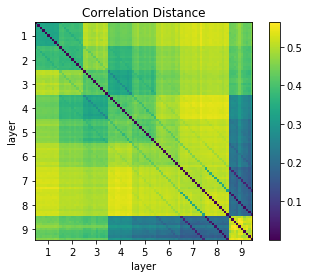

In [3]:
from matplotlib.pyplot import imshow
svcca_correlations = np.load('cca_correlations_version_4.npy')
svcca_correlations_distance = 1 - svcca_correlations
plt.title('Correlation Distance')
plt.xlabel('layer')
plt.xticks(ticks=[5, 15, 25, 35, 45, 55, 65, 75, 85],
           labels=[1, 2, 3, 4, 5, 6, 7, 8, 9])
plt.yticks(ticks=[5, 15, 25, 35, 45, 55, 65, 75, 85],
           labels=[1, 2, 3, 4, 5, 6, 7, 8, 9])
plt.ylabel('layer')

plt.imshow(svcca_correlations_distance)
plt.colorbar()

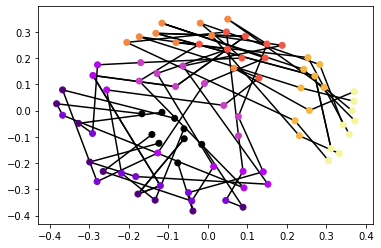

In [4]:
from sklearn.manifold import MDS
embedding = MDS(n_components=2, dissimilarity='precomputed')

X_transformed = embedding.fit_transform(svcca_correlations_distance)
X_transformed.shape

colors = ['#f5f59d', '#f5b642', '#f58742', '#f55442', '#c940c5',
          '#b407ed', '#7d09d6', '#50017a', '#000000']
plt.plot(X_transformed[::10, 0], X_transformed[::10, 1], linestyle='-', color='black', zorder=1)
plt.plot(X_transformed[1::10, 0], X_transformed[1::10, 1], linestyle='-', color='black', zorder=1)
plt.plot(X_transformed[2::10, 0], X_transformed[2::10, 1], linestyle='-', color='black', zorder=1)
plt.plot(X_transformed[3::10, 0], X_transformed[3::10, 1], linestyle='-', color='black', zorder=1)
plt.plot(X_transformed[4::10, 0], X_transformed[4::10, 1], linestyle='-', color='black', zorder=1)
plt.plot(X_transformed[5::10, 0], X_transformed[5::10, 1], linestyle='-', color='black', zorder=1)
plt.plot(X_transformed[6::10, 0], X_transformed[6::10, 1], linestyle='-', color='black', zorder=1)
plt.plot(X_transformed[7::10, 0], X_transformed[7::10, 1], linestyle='-', color='black', zorder=1)
plt.plot(X_transformed[8::10, 0], X_transformed[8::10, 1], linestyle='-', color='black', zorder=1)
plt.plot(X_transformed[::10, 0], X_transformed[::10, 1], linestyle='-', color='black', zorder=1)

plt.scatter(X_transformed[::10, 0], X_transformed[::10, 1], marker='o', color=colors, zorder=2)
plt.scatter(X_transformed[1::10, 0], X_transformed[1::10, 1], marker='o', color=colors, zorder=2)
plt.scatter(X_transformed[2::10, 0], X_transformed[2::10, 1], marker='o', color=colors, zorder=2)
plt.scatter(X_transformed[3::10, 0], X_transformed[3::10, 1], marker='o', color=colors, zorder=2)
plt.scatter(X_transformed[4::10, 0], X_transformed[4::10, 1], marker='o', color=colors, zorder=2)
plt.scatter(X_transformed[5::10, 0], X_transformed[5::10, 1], marker='o', color=colors, zorder=2)
plt.scatter(X_transformed[6::10, 0], X_transformed[6::10, 1], marker='o', color=colors, zorder=2)
plt.scatter(X_transformed[7::10, 0], X_transformed[7::10, 1], marker='o', color=colors, zorder=2)
plt.scatter(X_transformed[8::10, 0], X_transformed[8::10, 1], marker='o', color=colors, zorder=2)


In [5]:
import pwcca

num_images = len(x_predict) # 1000
num_networks = 10
num_layers = 9
rep_list = [[], [], [], [], [], [], [], [], []]

# Loop through network instances
for i in range(num_networks):
    print('Working on model', str(i))
    K.clear_session()
    full_model = load_model('../outputs/models/primary/Version_4/all_cnn_c_instance_' + str(i) + '.h5')
    inp = full_model.input
    # Loop through layers
    for j in range(num_layers):
        print('Layer', str(j))
        out = full_model.layers[j].output
        temp_model = Model(inputs=inp, outputs=out)
        # Predict on x_predict
        print('Getting representation...')
        representations = temp_model.predict(x_predict)
        print('Old shape:', representations.shape)
        # Average pool along spacial dimensions, transpose to fit shape (imgs, neurons)
        if (len(representations.shape) > 2):
            avg = np.mean(representations, axis=(1,2)).T
            print('Avg shape:', avg.shape)
        else:
            avg = representations.T
            print('No need to flatten')
        rep_list[j].append(avg)
        
print('Done preprocessing representations and thresholds, now CCA')
pwcca_correlations = np.empty((num_layers * num_networks, num_layers * num_networks))
for i in range(pwcca_correlations.shape[0]):
    for j in range(pwcca_correlations.shape[1]):
        print('Correlation', str(i), ',', str(j))
        
        layer_i = i // num_networks
        network_i = i % num_networks
        layer_j = j // num_networks
        network_j = j % num_networks
        
        # pwcca is order-dependent, so swap around to make symmetric
        if (i >= j):
            acts1 = rep_list[layer_i][network_i]
            acts2 = rep_list[layer_j][network_j]
        else:
            acts1 = rep_list[layer_j][network_j]
            acts2 = rep_list[layer_i][network_i]        
        
        # Do pwcca, acts1 needs to have dim <= acts2
        if (acts1.shape[0] <= acts2.shape[0]):
            pwcca_correlations[i, j] = pwcca.compute_pwcca(acts1, acts2, epsilon=1e-10)[0]
        else:
            pwcca_correlations[i, j] = pwcca.compute_pwcca(acts2, acts1, epsilon=1e-10)[0]

np.save('pwcca_correlations.npy', pwcca_correlations)
print('Done!')

Working on model 0
Layer 0
Getting representation...
Old shape: (1000, 32, 32, 96)
Avg shape: (96, 1000)
Layer 1
Getting representation...
Old shape: (1000, 32, 32, 96)
Avg shape: (96, 1000)
Layer 2
Getting representation...
Old shape: (1000, 16, 16, 96)
Avg shape: (96, 1000)
Layer 3
Getting representation...
Old shape: (1000, 16, 16, 192)
Avg shape: (192, 1000)
Layer 4
Getting representation...
Old shape: (1000, 16, 16, 192)
Avg shape: (192, 1000)
Layer 5
Getting representation...
Old shape: (1000, 8, 8, 192)
Avg shape: (192, 1000)
Layer 6
Getting representation...
Old shape: (1000, 6, 6, 192)
Avg shape: (192, 1000)
Layer 7
Getting representation...
Old shape: (1000, 6, 6, 192)
Avg shape: (192, 1000)
Layer 8
Getting representation...
Old shape: (1000, 6, 6, 10)
Avg shape: (10, 1000)
Working on model 1
Layer 0
Getting representation...
Old shape: (1000, 32, 32, 96)
Avg shape: (96, 1000)
Layer 1
Getting representation...
Old shape: (1000, 32, 32, 96)
Avg shape: (96, 1000)
Layer 2
Gettin

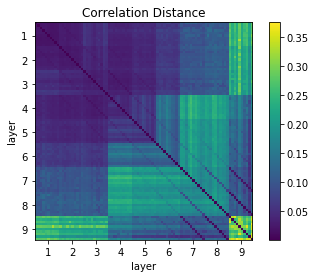

In [6]:
from matplotlib.pyplot import imshow
pwcca_correlations = np.load('pwcca_correlations.npy')
pwcca_correlations_distance = 1 - pwcca_correlations
plt.title('Correlation Distance')
plt.xlabel('layer')
plt.xticks(ticks=[5, 15, 25, 35, 45, 55, 65, 75, 85],
           labels=[1, 2, 3, 4, 5, 6, 7, 8, 9])
plt.yticks(ticks=[5, 15, 25, 35, 45, 55, 65, 75, 85],
           labels=[1, 2, 3, 4, 5, 6, 7, 8, 9])
plt.ylabel('layer')

plt.imshow(pwcca_correlations_distance)
plt.colorbar()

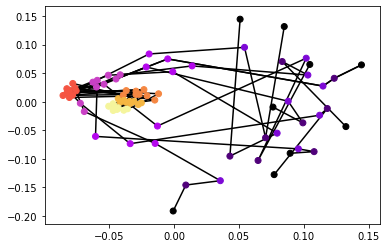

In [7]:
# pwcca_correlations_distance.shape
from sklearn.manifold import MDS
embedding = MDS(n_components=2, dissimilarity='precomputed')

X_transformed = embedding.fit_transform(pwcca_correlations_distance.astype('float64'))
X_transformed.shape

colors = ['#f5f59d', '#f5b642', '#f58742', '#f55442', '#c940c5',
          '#b407ed', '#7d09d6', '#50017a', '#000000']
plt.plot(X_transformed[::10, 0], X_transformed[::10, 1], linestyle='-', color='black', zorder=1)
plt.plot(X_transformed[1::10, 0], X_transformed[1::10, 1], linestyle='-', color='black', zorder=1)
plt.plot(X_transformed[2::10, 0], X_transformed[2::10, 1], linestyle='-', color='black', zorder=1)
plt.plot(X_transformed[3::10, 0], X_transformed[3::10, 1], linestyle='-', color='black', zorder=1)
plt.plot(X_transformed[4::10, 0], X_transformed[4::10, 1], linestyle='-', color='black', zorder=1)
plt.plot(X_transformed[5::10, 0], X_transformed[5::10, 1], linestyle='-', color='black', zorder=1)
plt.plot(X_transformed[6::10, 0], X_transformed[6::10, 1], linestyle='-', color='black', zorder=1)
plt.plot(X_transformed[7::10, 0], X_transformed[7::10, 1], linestyle='-', color='black', zorder=1)
plt.plot(X_transformed[8::10, 0], X_transformed[8::10, 1], linestyle='-', color='black', zorder=1)
plt.plot(X_transformed[::10, 0], X_transformed[::10, 1], linestyle='-', color='black', zorder=1)

plt.scatter(X_transformed[::10, 0], X_transformed[::10, 1], marker='o', color=colors, zorder=2)
plt.scatter(X_transformed[1::10, 0], X_transformed[1::10, 1], marker='o', color=colors, zorder=2)
plt.scatter(X_transformed[2::10, 0], X_transformed[2::10, 1], marker='o', color=colors, zorder=2)
plt.scatter(X_transformed[3::10, 0], X_transformed[3::10, 1], marker='o', color=colors, zorder=2)
plt.scatter(X_transformed[4::10, 0], X_transformed[4::10, 1], marker='o', color=colors, zorder=2)
plt.scatter(X_transformed[5::10, 0], X_transformed[5::10, 1], marker='o', color=colors, zorder=2)
plt.scatter(X_transformed[6::10, 0], X_transformed[6::10, 1], marker='o', color=colors, zorder=2)
plt.scatter(X_transformed[7::10, 0], X_transformed[7::10, 1], marker='o', color=colors, zorder=2)
plt.scatter(X_transformed[8::10, 0], X_transformed[8::10, 1], marker='o', color=colors, zorder=2)
